# Regression - Training and Testing

Here, we're going to make a regression algorithm to predict "Adj Close" price of a stock.

## Goal

Implement a Regression algorithm that trains and tests a trading a symbol to predict its price value.

## Import libraries

In [43]:
import pandas as pd
import numpy as np  
import datetime as dt
import math
import datetime

# To fetch data
from pandas_datareader import data as pdr   
import fix_yahoo_finance as yf  
yf.pdr_override()   

# sklearn
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression

# Utils
from util import fetchOnlineData

# Add plotly for interactive charts
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools

## Initial variables



In [44]:
symbol = "AMZN"
# Specify the start and end dates for this period.
start_d = dt.datetime(2008, 1, 1)
#end_d = dt.datetime(2018, 10, 30)
yesterday = dt.date.today() - dt.timedelta(1)
end_d = yesterday

### Get portfolio data from Yahoo

In [45]:
df = fetchOnlineData(start_d, end_d, symbol)

[*********************100%***********************]  1 of 1 downloaded


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2747 entries, 2007-12-31 to 2018-11-26
Data columns (total 6 columns):
Open         2747 non-null float64
High         2747 non-null float64
Low          2747 non-null float64
Close        2747 non-null float64
Adj Close    2747 non-null float64
Volume       2747 non-null int64
dtypes: float64(5), int64(1)
memory usage: 150.2 KB


## Features and label

In our case, what are the features and what is the label? We're trying to predict the price, so is price the label? If so, what are the featuers? When it comes to forecasting out the price, our label, the thing we're hoping to predict, is actually the future price. As such, our features are actually: current price, high minus low percent, and the percent change volatility. The price that is the label shall be the price at some determined point the future. 

In [47]:
df = df[['Open',  'High',  'Low',  'Close', 'Volume']]

df['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
df['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
df = df[['Close', 'HL_PCT', 'PCT_change', 'Volume']]

print(df.head())

                Close    HL_PCT  PCT_change    Volume
Date                                                 
2007-12-31  92.639999  2.072545   -1.247201   5755200
2008-01-02  96.250000  2.836367    0.943893  13858700
2008-01-03  95.209999  2.867349   -0.884863   9122500
2008-01-04  88.790001  5.518642   -4.793053  10270000
2008-01-07  88.820000  5.741949    0.225679   9981600


## Fill NaN data

We fill any NaN data with -99999. It's a popular option is to replace missing data with -99,999. With many machine learning classifiers, this will just be recognized and treated as an outlier feature.

In [48]:
forecast_col = 'Close'
df.fillna(value=-99999, inplace=True)

## Forecast out

We're saying we want to forecast out 1% of the entire length of the dataset. Thus, if our data is 100 days of stock prices, we want to be able to predict the price 1 day out into the future. Choose whatever you like. If you are just trying to predict tomorrow's price, then you would just do 1 day out, and the forecast would be just one day out. If you predict 10 days out, we can actually generate a forcast for every day, for the next week and a half.

In [49]:
forecast_out = int(math.ceil(0.01 * len(df)))

## Shift the values

https://stackoverflow.com/questions/44675650/what-is-meant-by-shift-in-dataframe

In [50]:
df['label'] = df[forecast_col].shift(-forecast_out)

## Drop NaN values

We'll then drop any still NaN information from the dataframe.

In [51]:
df.dropna(inplace=True)

##  Define our features and labels as arrays and preprocessing

Generally, you want your features in machine learning to be in a range of -1 to 1. This may do nothing, but it usually speeds up processing and can also help with accuracy. 

In [52]:
X = np.array(df.drop(['label'], 1))
y = np.array(df['label'])

## Create the label 'y'

In [53]:
y = np.array(df['label'])

# Training and testing

Now comes the training and testing. The way this works is you take, for example, 75% of your data, and use this to train the machine learning classifier. Then you take the remaining 25% of your data, and test the classifier. Since this is your sample data, you should have the features and known labels. Thus, if you test on the last 25% of your data, you can get a sort of accuracy and reliability, often called the confidence score. There are many ways to do this, but, probably the best way is using the build in cross_validation provided, since this also shuffles your data for you. 

In [54]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)

## Classifier

Let's use Linear Regression from Scikit-Learn's svm package

In [55]:
clf = LinearRegression()

## Training

In [56]:
clf.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

## Testing

In [57]:
confidence = clf.score(X_test, y_test)

## Confidence

In [58]:
print("Confidence: ", confidence)

Confidence:  0.9839083383427016


## Forecasting results

In [59]:
X_lately = X[-forecast_out:]
forecast_set = clf.predict(X_lately)

In [60]:
print(forecast_set, confidence, forecast_out)

[2004.26360477 1990.46258122 2041.34406763 2043.30190731 2043.88775012
 2023.57363341 1955.74550096 1994.01094908 1978.46666032 1998.10465881
 1962.98037889 1987.78496954 2028.06066483 2028.08490227 2067.26389523
 2056.96484126 2058.80231364 2022.60462318 2003.70030048 1956.92360837
 1937.54588919 1911.48761719 1920.81116279 1793.88575112 1755.14891134
 1831.13323468 1806.14160084 1868.79176984] 0.9839083383427016 28


# Visualizing

Stock prices are daily, for 5 days, and then there are no prices on the weekends. I recognize this fact, but we're going to keep things simple, and plot each forecast as if it is simply 1 day out. If you want to try to work in the weekend gaps (don't forget holidays) go for it, but we'll keep it simple.

## Adding forecast column

We set the value as a NaN first, but we'll populate some shortly. We said we're going to just start the forecasts as tomorrow (recall that we predict 10% out into the future, and we saved that last 10% of our data to do this, thus, we can begin immediately predicting since -10% has data that we can predict 10% out and be the next prediction)

In [61]:
df['Forecast'] = np.nan

## Setting dates

We set the value as a NaN first, but we'll populate some shortly. We said we're going to just start the forecasts as tomorrow (recall that we predict 10% out into the future, and we saved that last 10% of our data to do this, thus, we can begin immediately predicting since -10% has data that we can predict 10% out and be the next prediction). We need to first grab the last day in the dataframe, and begin assigning each new forecast to a new day.

In [62]:
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

## Forecasting the existing dataframe

Now we have the next day we wish to use, and one_day is 86,400 seconds. Now we add the forecast to the existing dataframe.

So here all we're doing is iterating through the forecast set, taking each forecast and day, and then setting those values in the dataframe (making the future "features" NaNs). The last line's code just simply takes all of the first columns, setting them to NaNs, and then the final column is whatever i is (the forecast in this case). I have chosen to do this one-liner for loop like this so that, if we decide to change up the dataframe and features, the code can still work. 

In [63]:
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]

In [65]:
df['Close']



Date
2007-12-31 00:00:00      92.639999
2008-01-02 00:00:00      96.250000
2008-01-03 00:00:00      95.209999
2008-01-04 00:00:00      88.790001
2008-01-07 00:00:00      88.820000
2008-01-08 00:00:00      87.879997
2008-01-09 00:00:00      85.220001
2008-01-10 00:00:00      84.260002
2008-01-11 00:00:00      81.080002
2008-01-14 00:00:00      82.870003
2008-01-15 00:00:00      80.239998
2008-01-16 00:00:00      80.349998
2008-01-17 00:00:00      80.120003
2008-01-18 00:00:00      79.760002
2008-01-22 00:00:00      78.480003
2008-01-23 00:00:00      73.970001
2008-01-24 00:00:00      77.669998
2008-01-25 00:00:00      77.599998
2008-01-28 00:00:00      75.820000
2008-01-29 00:00:00      73.949997
2008-01-30 00:00:00      74.209999
2008-01-31 00:00:00      77.699997
2008-02-01 00:00:00      74.629997
2008-02-04 00:00:00      73.949997
2008-02-05 00:00:00      72.089996
2008-02-06 00:00:00      68.489998
2008-02-07 00:00:00      70.910004
2008-02-08 00:00:00      73.500000
2008-02-11 00:0

## Plotting

In [66]:
def plot_price_forecast(df_index, price, forecast_price, symbol="AMZN", title="Stock prices forecasting for ", xlabel="Date", ylabel="Price", fig_size=(12, 6)):
    """Plot Stock Prices.

    Parameters:
    df_index: Date index
    price: Price, typically adjusted close price, series of symbol
    forecast: Forecast price
    symbol: Stock symbol
    title: Chart title
    xlabel: X axis title
    ylable: Y axis title
    fig_size: Width and height of the chart in inches
    
    Returns:
    Plot forecast prices
    """
    trace_prices = go.Scatter(
                x=df_index,
                y=price,
                name = "Price",
                line = dict(color = '#17BECF'),
                opacity = 0.8)

    trace_forecast_price = go.Scatter(
                x=df_index,
                y=forecast_price,
                name = "Forecast price",
                line = dict(color = '#FF8000'),
                opacity = 0.8)
        

    data = [trace_prices, trace_forecast_price]

    layout = dict(
        title = title + symbol,
        showlegend=True,
        xaxis = dict(
                title=xlabel,
                linecolor='#000', linewidth=1,
                rangeselector=dict(
                        buttons=list([
                            dict(count=1,
                                 label='1m',
                                 step='month',
                                 stepmode='backward'),
                            dict(count=6,
                                 label='6m',
                                 step='month',
                                 stepmode='backward'),
                            dict(step='all')
                        ])
                ),
                range = [df_index.values[0], df_index.values[1]]),
            
        yaxis = dict(
                title=ylabel,
                linecolor='#000', linewidth=1
                ),
    )
        
        
        

    fig = dict(data=data, layout=layout)
    iplot(fig)

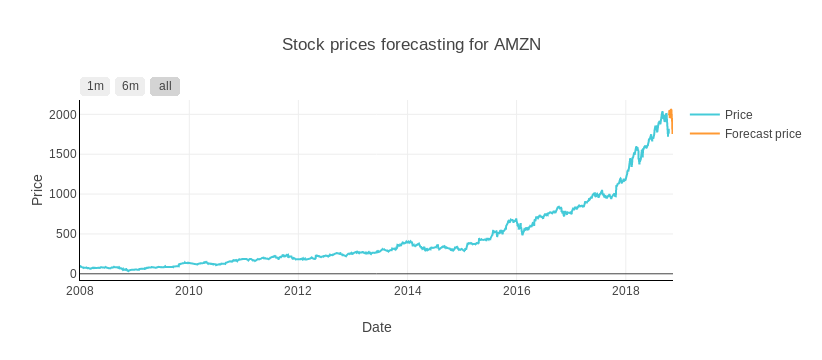

In [67]:
plot_price_forecast(df.index, df['Close'], df['Forecast'], symbol=symbol)
